In [1]:
import copy
class person:
    """
    The item class, which record the change of the properties and the customer
    of the item
    """
    def __init__(self, id):
        self.person_id = id
        self.purchased_category = {}
        self.viewed_or_carted_category = {}
        self.total_purchased_num = 0
        self.total_viewd_or_carted_num = 0

In [2]:
class analyse():
    """
    the class to read and store data
    """
    def __init__(self):
        self.persons = {}
        self.category_id_dic = {}
        self.category_to_id_dic = {}
    def find_category_id(self, property_file):
        """
        find the corresponding category id for each id
        """
        f, first = open(property_file, "r"), True
        for line in f:
            if first:
                first = False
                continue
            property_info = line.split(",")
            
            item_id, pro_name, value = property_info[1], property_info[2], property_info[3]
            if len(pro_name)>0 and pro_name[-1] == "\n":
                pro_name = pro_name[:-1]
            if pro_name != "categoryid":
                continue
            if len(value)>0 and value[-1] == "\n":
                value = value[:-1]
            if len(item_id)>0 and item_id[-1] == "\n":
                item_id = item_id[:-1]
            self.category_id_dic[item_id] = value
            if value not in self.category_to_id_dic:
                self.category_to_id_dic[value] = []
            self.category_to_id_dic[value].append(item_id)
    def read_event(self, event_file):
        f, first = open(event_file, "r"), True
        count, no_cate = 0, 0
        for line in f:
            if first:
                first = False
                continue
            count += 1
            event_info = line.split(",")
            person_id, event, item_id =  event_info[1], event_info[2], event_info[3]
            category_id = None
            if len(item_id) > 0 and item_id[-1] == "\n":
                item_id = item_id[:-1]
            if item_id not in self.category_id_dic:
                no_cate += 1
                category_id = item_id
            else:
                category_id = self.category_id_dic[item_id]
            if person_id not in self.persons:
                self.persons[person_id] = person(person_id)
            
            if event == "transaction":
                self.persons[person_id].purchased_category[category_id] = self.persons[person_id].purchased_category.get(category_id, 0) + 1
                self.persons[person_id].total_purchased_num += 1
            else:
                self.persons[person_id].viewed_or_carted_category[category_id] = self.persons[person_id].viewed_or_carted_category.get(category_id, 0) + 1
                self.persons[person_id].total_viewd_or_carted_num += 1
        print count, no_cate
data = analyse()
data.find_category_id("/Users/Kiki/Downloads/retailrocket-recommender-system-dataset/item_properties_part1.csv")
data.find_category_id("/Users/Kiki/Downloads/retailrocket-recommender-system-dataset/item_properties_part2.csv")
data.read_event("/Users/Kiki/Downloads/retailrocket-recommender-system-dataset/events.csv")

2756101 255585


In [3]:
def subset(data, threshold):
    """
    preprocess users in a, filter the users according to its purchased, viewd, and carted items
    :param threshold: int
    :return: {}
    """
    res = {}
    for p_name, person in data.persons.items():
        if person.total_purchased_num > threshold and person.total_viewd_or_carted_num > threshold:
            res[p_name] = copy.deepcopy(person)
    return res

In [4]:
subset_persons = subset(data, 2)

print len(subset_persons.keys())

1016


In [5]:
def category(persons):
    """
    give back a list of category given the persons
    :param persons: dic
    :return: []
    """
    res = []
    dic = {}
    
    for p_name, person in persons.items():
        
        for category_id in person.purchased_category:
            if category_id not in dic:
                res.append(category_id)
                dic[category_id] = True
        for category_id in person.viewed_or_carted_category:
            if category_id not in dic:
                res.append(category_id)
                dic[category_id] = True
    
    return res

In [6]:
subset_category = category(subset_persons)

In [7]:
def cal_score(persons, categories):
    """
    give back a scores dictionary recording the score of each category for each person
    :param persons: dic
    :param categories: list
    :return: {}
    """
    scores = {}
    for p_name, person in persons.items():
        scores[p_name], total = {}, 0
        for c_id in categories:
            scores[p_name][c_id] = 0
        for c_id, times in person.purchased_category.items():
            scores[p_name][c_id]  += times
            total += times
        for c_id, times in person.viewed_or_carted_category.items():
            scores[p_name][c_id] += 0.5 * times
            total += 0.5 * times
        for k in scores[p_name]:
            scores[p_name][k] = (scores[p_name][k]*1.0/total)
        
    return scores
        

In [8]:
scores = cal_score(subset_persons, subset_category)

In [9]:
import pandas as pd
import numpy as np

In [10]:
import random
def create_table(scores, categories):
    """
    create a scores table
    :param scores: dic
    :param categories: list
    :return: {}
    """
    persons_names = scores.keys()
    categories
    person_list = []
    category_list = []
    score_list = []
    for person_name in persons_names:
        for c_id in categories:
            person_list.append(person_name)
            category_list.append(c_id)
            score_list.append(scores[person_name][c_id])
    dic = {"person" : person_list, 'categoryid':category_list, 'score':score_list}
    return pd.DataFrame(dic,columns=['person','categoryid','score'])

    

In [11]:
df = create_table(scores, subset_category)

In [12]:
df.head()

,person,categoryid,score
0,625795,1421,0.050725
1,625795,618,0.090580
2,625795,619,0.014493
3,625795,352,0.014493
4,625795,1261,0.003623


In [13]:
def find_sets(df, percentage):
    """
    find a training set and a test set, and add(change) the random column
    :param df: DataFrame
    :return: {}, {}
    """
    ran_list, tr_set, te_set  = [], {}, {}
    num_tr, num_te = 0, 0
    for i in range(df.shape[0]):
        if i % 100000 == 0:
            print "dividing sets finished " + str(100.0*i/df.shape[0]) +"%"
        ran_num = round(random.uniform(0, 1),2)
        ran_list.append(ran_num)
        p_name , c_id, score = df.loc[i, "person"], df.loc[i, "categoryid"],df.loc[i, "score"]
        if ran_num < percentage and p_name in tr_set:
            num_te += 1
            if p_name not in te_set:
                te_set[p_name] = {}
            te_set[p_name][c_id] = score
        else:
            num_tr += 1
            if p_name not in tr_set:
                tr_set[p_name] = {}
            tr_set[p_name][c_id] = score
    print "number of data in training set: " + str(num_tr)
    print "number of data in test set:" + str(num_te)    
    df.assign(random = ran_list)
    return tr_set, te_set

In [164]:
tr_set, te_set = find_sets(df,0.2)

finished 0.0%
finished 5.01657476302%
finished 10.033149526%
finished 15.0497242891%
finished 20.0662990521%
finished 25.0828738151%
finished 30.0994485781%
finished 35.1160233411%
finished 40.1325981041%
finished 45.1491728672%
finished 50.1657476302%
finished 55.1823223932%
finished 60.1988971562%
finished 65.2154719192%
finished 70.2320466822%
finished 75.2486214453%
finished 80.2651962083%
finished 85.2817709713%
finished 90.2983457343%
finished 95.3149204973%
number of data in training set: 1603819
number of data in test set:389573


In [14]:
import math
def pearson(person1, person2):
    p1_key = person1.keys()
    p2_key = person2.keys()
    common_cate_id = list(set(p1_key).intersection(p2_key))
    aver_person1 = sum(person1.values())*1.0/ len(person1)
    aver_person2 = sum(person2.values())*1.0/ len(person2)
    numerator = 0
    for c_id in common_cate_id:
        numerator += (person1[c_id] - aver_person1)*(person2[c_id] - aver_person2)
    denominator,temp1,temp2 = 0, 0, 0 
    for c_id in common_cate_id:
        temp1 += (person1[c_id] - aver_person1)**2
        temp2 += (person2[c_id] - aver_person2)**2
     
    denominator = math.sqrt(temp1) * math.sqrt(temp2)
    if denominator == 0:
        return -float("inf")
    return numerator*1.0/denominator

In [15]:
def Jaccard(person1, person2):
    p1_key = person1.keys()
    p2_key = person2.keys()
    common_cate_id = set(p1_key).intersection(p2_key)
    return len(common_cate_id)*1.0/(len(p1_key) + len(p2_key) - len(common_cate_id))

In [16]:
import Queue as Q
def knn_list(scores, k, test_set):
    knn = {}
    if k > len(scores) - 1:
        raise Exception('k can not be larger than len(scores) - 1!')
    persons_list = scores.keys()
    index  = 0
    for p_name, p_scores in scores.items():
        if index % 1000 ==0 :
            print "finding "+str(k)+ " nearest neighbours finished " + str(100.0*index/len(scores)) +"%"
        index += 1
        if p_name not in test_set:
            continue
        temp_q, knn[p_name] = Q.PriorityQueue(), []
        
        for other_pname in persons_list:
            if other_pname == p_name:
                continue
            person2_scores = scores[other_pname]
            p_score = pearson(p_scores, person2_scores)
            j_score = Jaccard(p_scores, person2_scores)
            neg = False
            
            if p_score < 0:
                neg = True
            score = 0.5* abs(p_score)+ 0.5 * j_score
            if neg:
                score = - score
            temp_q.put((- score, other_pname))
            
        for i in range(k):
            temp_score = temp_q.get()
            knn[p_name].append((temp_score[1], -temp_score[0]))
    return knn
        

In [16]:
def ave(scores_set):
    res_dic = {}
    for p_name, p_scores in scores_set.items():
        tot_v, tot_n = 0, 0
        for c_id, score in p_scores.items():
            if score >0 :
                tot_v += score
                tot_n += 1
        if tot_n == 0:
            res_dic[p_name] = 0
        else:
            res_dic[p_name] = 1.0* tot_v / tot_n
    return res_dic

In [364]:
tra_ave = ave(tr_set)

In [17]:
import math
def prediction(training_set, knn, test_set):
    pre = {}
    index = 1.0
    for p_name, p_scores in test_set.items():
        # the scores recorded in test_set
        if p_name not in pre:
            pre[p_name] = {}
        
        index += 1
        
        for c_id in p_scores:
            numerator, denominator = 0, 0
            
            for nei_name, sim_score in knn[p_name]:
                if c_id not in training_set[nei_name]:
                    continue
                if abs(sim_score) == float('inf'):
                    break
                
                
                denominator += abs(sim_score) 
                numerator += training_set[nei_name][c_id] * sim_score
            if denominator!= 0:
                pre[p_name][c_id] =  1.0*numerator/denominator
            else:
                pre[p_name][c_id] = 0
    return pre
            

In [240]:
neighbours= knn_list(tr_set,len(tr_set)-1,te_set)
#dont touch it!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

finding 1015 nearest neighbours finished 0.0%
finding 1015 nearest neighbours finished 9.84251968504%
finding 1015 nearest neighbours finished 19.6850393701%
finding 1015 nearest neighbours finished 29.5275590551%
finding 1015 nearest neighbours finished 39.3700787402%
finding 1015 nearest neighbours finished 49.2125984252%
finding 1015 nearest neighbours finished 59.0551181102%
finding 1015 nearest neighbours finished 68.8976377953%
finding 1015 nearest neighbours finished 78.7401574803%
finding 1015 nearest neighbours finished 88.5826771654%
finding 1015 nearest neighbours finished 98.4251968504%


In [366]:
neighbours_list = [{} for _ in range(len(tr_set)-1)]
#dont touch it!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
for p_name in neighbours:
    for i in range(len(tr_set)-1):
        neighbours_list[i][p_name] =neighbours[p_name][:i+1]

In [18]:
def baseline(tr_set, test_set):
    pre = {}
    ave = {}
    num = {}
    for p_name, p_scores in tr_set.items():
        for c_id, score in p_scores.items():
            ave[c_id] = ave.get(c_id, 0) + score
            num[c_id] = num.get(c_id, 0) + 1
    for c_id in ave:
        ave[c_id] = ave[c_id] * 1.0 / num[c_id]
    for p_name, p_scores in test_set.items():
        # the scores recorded in test_set
        if p_name not in pre:
            pre[p_name] = {}
        for c_id in p_scores:
            if c_id in ave:
                pre[p_name][c_id] = ave[c_id]
            else:
                pre[p_name][c_id] = 0
    return pre

In [381]:
bl = baseline(tr_set, te_set)

In [19]:

def MSE(pre_set, te_set):
    tot_num, res = 0, 0
    for p_name, p_scores in pre_set.items():
        for c_id in p_scores:
            res += (pre_set[p_name][c_id] - te_set[p_name][c_id])**2
            tot_num += 1
    return res*1.0/tot_num

In [383]:
resbl = MSE(bl, te_set)
print("the MSE for baseline model is " + str(resbl))


the MSE for baseline model is 0.00016669992478


In [446]:
prediction_list = [None for _ in range(len(tr_set)-1)]
min_MSE, optimal_k = float("inf"), None
MSE_res = []
for i in range(len(tr_set)-1):
    
    prediction_list[i] = prediction(tr_set, neighbours_list[i], te_set)
    res = MSE(prediction_list[i], te_set)
    if min_MSE > res:
        min_MSE = res
        optimal_k = i + 1
    MSE_res.append(res)
    print("the MSE for " + str(i+1) + "nn model is " + str(res))

the MSE for 1nn model is 0.000490256096601
the MSE for 2nn model is 0.000388349001133
the MSE for 3nn model is 0.000307454659837
the MSE for 4nn model is 0.0002581811936
the MSE for 5nn model is 0.000235224157189
the MSE for 6nn model is 0.00022003248498
the MSE for 7nn model is 0.000207982902947
the MSE for 8nn model is 0.000199291347219
the MSE for 9nn model is 0.000193789896009
the MSE for 10nn model is 0.000188973551276
the MSE for 11nn model is 0.000185764424111
the MSE for 12nn model is 0.000182203955404
the MSE for 13nn model is 0.000179279513345
the MSE for 14nn model is 0.000177021356475
the MSE for 15nn model is 0.000175275188676
the MSE for 16nn model is 0.000173797617944
the MSE for 17nn model is 0.000172724370913
the MSE for 18nn model is 0.000171721276613
the MSE for 19nn model is 0.000170870714055
the MSE for 20nn model is 0.000170090274979
the MSE for 21nn model is 0.000169326107148
the MSE for 22nn model is 0.000168406461871
the MSE for 23nn model is 0.000167759875688


KeyboardInterrupt: 

In [20]:

import heapq
import heapq
def recommend_dic(tr_set, pre_set):
    hq_dic = {}
    com_dic = {}    
    for p_name, p_scores in tr_set.items():
        hq_dic[p_name] = []
        com_dic[p_name] = []
        for c_id, score in p_scores.items():
            heapq.heappush(hq_dic[p_name],(- score,c_id))
        if p_name in pre_set:
            for c_id, score in pre_set[p_name].items():
                heapq.heappush(hq_dic[p_name],(- score,c_id))
        
        for i in range(20):
            score, c_id = heapq.heappop(hq_dic[p_name])
            score = - score
            com_dic[p_name].append(c_id)
    return com_dic
def real_dic(tr_set, pre_set):
    hq_dic = {}
    com_dic = {}    
    for p_name, p_scores in tr_set.items():
        hq_dic[p_name] = []
        com_dic[p_name] = []
        for c_id, score in p_scores.items():
            if score > 0:
                heapq.heappush(hq_dic[p_name],(- score,c_id))
        if p_name in pre_set:
            for c_id, score in pre_set[p_name].items():
                if score > 0 :
                    heapq.heappush(hq_dic[p_name],(- score,c_id))
        index  = 0
        while i < 20 and len(hq_dic[p_name])>0:
            score, c_id = heapq.heappop(hq_dic[p_name])
            score = - score
            com_dic[p_name].append(c_id)
            index += 1
    return com_dic


        

In [410]:
predicted_recom = recommend_dic(tr_set, prediction_list[64])
real_recom = real_dic(tr_set, te_set)
res = {}
for p_name in real_recom:
    pre_set = set(predicted_recom[p_name])
    rea_set = set(real_recom[p_name])
    res[p_name] = 1.0*len(pre_set.intersection(rea_set))/len(rea_set)

In [411]:
print "Accuracy :" + str(sum(res.values())/len(res.values()))

Accuracy :0.801877264406


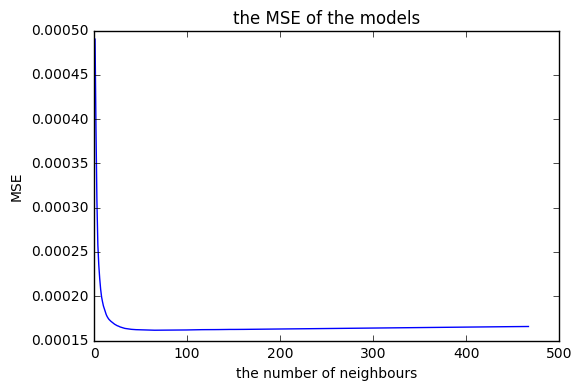

In [447]:
import pylab as pl
x = []
for i in range(len(MSE_res)):
    x.append(i+1)
pl.plot(x, MSE_res)
pl.title('the MSE of the models')
pl.xlabel('the number of neighbours')
pl.ylabel('MSE')
pl.show()

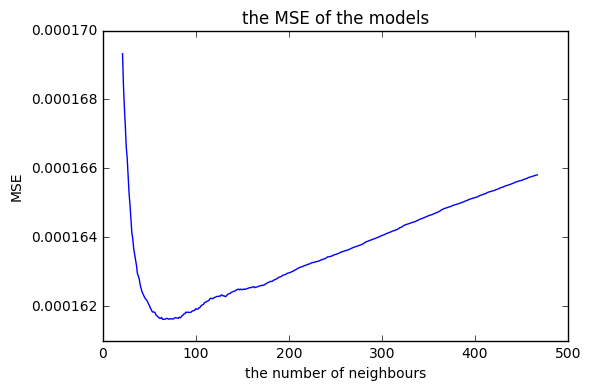

In [451]:

pl.plot(x[20:], MSE_res[20:])
pl.title('the MSE of the models')
pl.xlabel('the number of neighbours')
pl.ylabel('MSE')
pl.show()

In [452]:

acc = []
for i in range(len(x)):
    
    predicted_recom = recommend_dic(tr_set, prediction_list[i])
    res = {}
    for p_name in real_recom:
        pre_set = set(predicted_recom[p_name])
        rea_set = set(real_recom[p_name])
        res[p_name] = 1.0*len(pre_set.intersection(rea_set))/len(rea_set)
    acc.append(sum(res.values())/len(res.values()))
    print "Accuracy of " +str(i+1) + "nn = " + str(acc[-1])
    

Accuracy of 1nn = 0.734805689605
Accuracy of 2nn = 0.747328909122
Accuracy of 3nn = 0.7572014867
Accuracy of 4nn = 0.764605811364
Accuracy of 5nn = 0.769549493772
Accuracy of 6nn = 0.773567470326
Accuracy of 7nn = 0.779821296816
Accuracy of 8nn = 0.781911985527
Accuracy of 9nn = 0.783398509644
Accuracy of 10nn = 0.786183055474
Accuracy of 11nn = 0.788477662087
Accuracy of 12nn = 0.790411823446
Accuracy of 13nn = 0.79217108951
Accuracy of 14nn = 0.79394696229
Accuracy of 15nn = 0.795490804184
Accuracy of 16nn = 0.794725338824
Accuracy of 17nn = 0.796259759149
Accuracy of 18nn = 0.79688122517
Accuracy of 19nn = 0.796041498401
Accuracy of 20nn = 0.797046736192
Accuracy of 21nn = 0.797296835778
Accuracy of 22nn = 0.799007062707
Accuracy of 23nn = 0.799304212989
Accuracy of 24nn = 0.799804811067
Accuracy of 25nn = 0.800150691689
Accuracy of 26nn = 0.80039007475
Accuracy of 27nn = 0.800788115982
Accuracy of 28nn = 0.80111085954
Accuracy of 29nn = 0.80164681319
Accuracy of 30nn = 0.8027471443

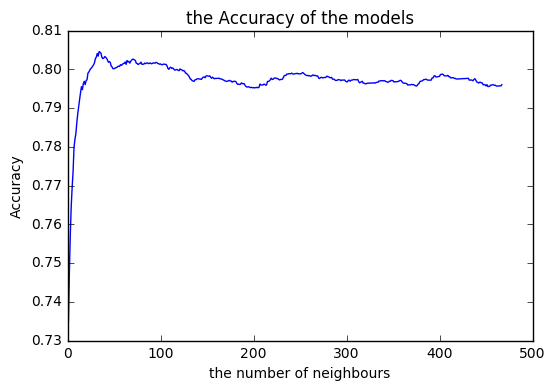

In [453]:

pl.plot(x, acc)
pl.title('the Accuracy of the models')
pl.xlabel('the number of neighbours')
pl.ylabel('Accuracy')
pl.show()

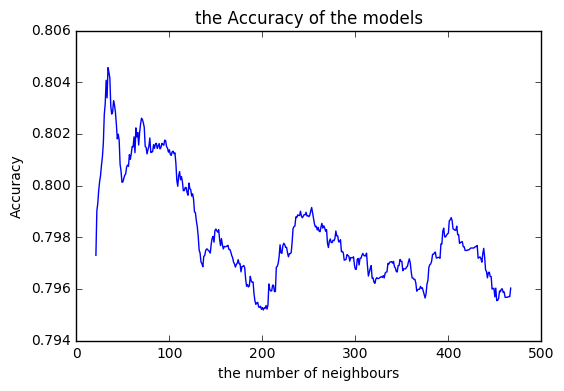

In [454]:
pl.plot(x[20:], acc[20:])
pl.title('the Accuracy of the models')
pl.xlabel('the number of neighbours')
pl.ylabel('Accuracy')
pl.show()

In [455]:
print "when k = " + str(acc.index(max(acc))+1) + ", the model reach the highest accuracy, the highest accuracy is " + str(max(acc))

when k = 34, the model reach the highest accuracy, the highest accuracy is 0.804562454965


In [21]:
tr_set55, te_set55 = find_sets(df,0.45)

dividing sets finished 0.0%
dividing sets finished 5.01657476302%
dividing sets finished 10.033149526%
dividing sets finished 15.0497242891%
dividing sets finished 20.0662990521%
dividing sets finished 25.0828738151%
dividing sets finished 30.0994485781%
dividing sets finished 35.1160233411%
dividing sets finished 40.1325981041%
dividing sets finished 45.1491728672%
dividing sets finished 50.1657476302%
dividing sets finished 55.1823223932%
dividing sets finished 60.1988971562%
dividing sets finished 65.2154719192%
dividing sets finished 70.2320466822%
dividing sets finished 75.2486214453%
dividing sets finished 80.2651962083%
dividing sets finished 85.2817709713%
dividing sets finished 90.2983457343%
dividing sets finished 95.3149204973%
number of data in training set: 1106683
number of data in test set:886709


In [22]:
tr_set60, te_set60 = find_sets(df,0.40)

dividing sets finished 0.0%
dividing sets finished 5.01657476302%
dividing sets finished 10.033149526%
dividing sets finished 15.0497242891%
dividing sets finished 20.0662990521%
dividing sets finished 25.0828738151%
dividing sets finished 30.0994485781%
dividing sets finished 35.1160233411%
dividing sets finished 40.1325981041%
dividing sets finished 45.1491728672%
dividing sets finished 50.1657476302%
dividing sets finished 55.1823223932%
dividing sets finished 60.1988971562%
dividing sets finished 65.2154719192%
dividing sets finished 70.2320466822%
dividing sets finished 75.2486214453%
dividing sets finished 80.2651962083%
dividing sets finished 85.2817709713%
dividing sets finished 90.2983457343%
dividing sets finished 95.3149204973%
number of data in training set: 1205179
number of data in test set:788213


In [23]:
tr_set65, te_set65 = find_sets(df,0.35)

dividing sets finished 0.0%
dividing sets finished 5.01657476302%
dividing sets finished 10.033149526%
dividing sets finished 15.0497242891%
dividing sets finished 20.0662990521%
dividing sets finished 25.0828738151%
dividing sets finished 30.0994485781%
dividing sets finished 35.1160233411%
dividing sets finished 40.1325981041%
dividing sets finished 45.1491728672%
dividing sets finished 50.1657476302%
dividing sets finished 55.1823223932%
dividing sets finished 60.1988971562%
dividing sets finished 65.2154719192%
dividing sets finished 70.2320466822%
dividing sets finished 75.2486214453%
dividing sets finished 80.2651962083%
dividing sets finished 85.2817709713%
dividing sets finished 90.2983457343%
dividing sets finished 95.3149204973%
number of data in training set: 1305664
number of data in test set:687728


In [24]:
tr_set70, te_set70 = find_sets(df,0.30)

dividing sets finished 0.0%
dividing sets finished 5.01657476302%
dividing sets finished 10.033149526%
dividing sets finished 15.0497242891%
dividing sets finished 20.0662990521%
dividing sets finished 25.0828738151%
dividing sets finished 30.0994485781%
dividing sets finished 35.1160233411%
dividing sets finished 40.1325981041%
dividing sets finished 45.1491728672%
dividing sets finished 50.1657476302%
dividing sets finished 55.1823223932%
dividing sets finished 60.1988971562%
dividing sets finished 65.2154719192%
dividing sets finished 70.2320466822%
dividing sets finished 75.2486214453%
dividing sets finished 80.2651962083%
dividing sets finished 85.2817709713%
dividing sets finished 90.2983457343%
dividing sets finished 95.3149204973%
number of data in training set: 1405869
number of data in test set:587523


In [31]:
tr_set50, te_set50 = find_sets(df,0.50)

dividing sets finished 0.0%
dividing sets finished 5.01657476302%
dividing sets finished 10.033149526%
dividing sets finished 15.0497242891%
dividing sets finished 20.0662990521%
dividing sets finished 25.0828738151%
dividing sets finished 30.0994485781%
dividing sets finished 35.1160233411%
dividing sets finished 40.1325981041%
dividing sets finished 45.1491728672%
dividing sets finished 50.1657476302%
dividing sets finished 55.1823223932%
dividing sets finished 60.1988971562%
dividing sets finished 65.2154719192%
dividing sets finished 70.2320466822%
dividing sets finished 75.2486214453%
dividing sets finished 80.2651962083%
dividing sets finished 85.2817709713%
dividing sets finished 90.2983457343%
dividing sets finished 95.3149204973%
number of data in training set: 1008707
number of data in test set:984685


In [26]:
tr_set75, te_set75 = find_sets(df,0.25)

dividing sets finished 0.0%
dividing sets finished 5.01657476302%
dividing sets finished 10.033149526%
dividing sets finished 15.0497242891%
dividing sets finished 20.0662990521%
dividing sets finished 25.0828738151%
dividing sets finished 30.0994485781%
dividing sets finished 35.1160233411%
dividing sets finished 40.1325981041%
dividing sets finished 45.1491728672%
dividing sets finished 50.1657476302%
dividing sets finished 55.1823223932%
dividing sets finished 60.1988971562%
dividing sets finished 65.2154719192%
dividing sets finished 70.2320466822%
dividing sets finished 75.2486214453%
dividing sets finished 80.2651962083%
dividing sets finished 85.2817709713%
dividing sets finished 90.2983457343%
dividing sets finished 95.3149204973%
number of data in training set: 1505381
number of data in test set:488011


In [32]:
tr_set80, te_set80 = find_sets(df,0.20)

dividing sets finished 0.0%
dividing sets finished 5.01657476302%
dividing sets finished 10.033149526%
dividing sets finished 15.0497242891%
dividing sets finished 20.0662990521%
dividing sets finished 25.0828738151%
dividing sets finished 30.0994485781%
dividing sets finished 35.1160233411%
dividing sets finished 40.1325981041%
dividing sets finished 45.1491728672%
dividing sets finished 50.1657476302%
dividing sets finished 55.1823223932%
dividing sets finished 60.1988971562%
dividing sets finished 65.2154719192%
dividing sets finished 70.2320466822%
dividing sets finished 75.2486214453%
dividing sets finished 80.2651962083%
dividing sets finished 85.2817709713%
dividing sets finished 90.2983457343%
dividing sets finished 95.3149204973%
number of data in training set: 1604018
number of data in test set:389374


In [33]:
tr_set85, te_set85 = find_sets(df,0.15)

dividing sets finished 0.0%
dividing sets finished 5.01657476302%
dividing sets finished 10.033149526%
dividing sets finished 15.0497242891%
dividing sets finished 20.0662990521%
dividing sets finished 25.0828738151%
dividing sets finished 30.0994485781%
dividing sets finished 35.1160233411%
dividing sets finished 40.1325981041%
dividing sets finished 45.1491728672%
dividing sets finished 50.1657476302%
dividing sets finished 55.1823223932%
dividing sets finished 60.1988971562%
dividing sets finished 65.2154719192%
dividing sets finished 70.2320466822%
dividing sets finished 75.2486214453%
dividing sets finished 80.2651962083%
dividing sets finished 85.2817709713%
dividing sets finished 90.2983457343%
dividing sets finished 95.3149204973%
number of data in training set: 1704303
number of data in test set:289089


In [34]:
tr_set90, te_set90 = find_sets(df,0.10)

dividing sets finished 0.0%
dividing sets finished 5.01657476302%
dividing sets finished 10.033149526%
dividing sets finished 15.0497242891%
dividing sets finished 20.0662990521%
dividing sets finished 25.0828738151%
dividing sets finished 30.0994485781%
dividing sets finished 35.1160233411%
dividing sets finished 40.1325981041%
dividing sets finished 45.1491728672%
dividing sets finished 50.1657476302%
dividing sets finished 55.1823223932%
dividing sets finished 60.1988971562%
dividing sets finished 65.2154719192%
dividing sets finished 70.2320466822%
dividing sets finished 75.2486214453%
dividing sets finished 80.2651962083%
dividing sets finished 85.2817709713%
dividing sets finished 90.2983457343%
dividing sets finished 95.3149204973%
number of data in training set: 1804445
number of data in test set:188947


In [35]:
tr_set95, te_set95 = find_sets(df,0.05)

dividing sets finished 0.0%
dividing sets finished 5.01657476302%
dividing sets finished 10.033149526%
dividing sets finished 15.0497242891%
dividing sets finished 20.0662990521%
dividing sets finished 25.0828738151%
dividing sets finished 30.0994485781%
dividing sets finished 35.1160233411%
dividing sets finished 40.1325981041%
dividing sets finished 45.1491728672%
dividing sets finished 50.1657476302%
dividing sets finished 55.1823223932%
dividing sets finished 60.1988971562%
dividing sets finished 65.2154719192%
dividing sets finished 70.2320466822%
dividing sets finished 75.2486214453%
dividing sets finished 80.2651962083%
dividing sets finished 85.2817709713%
dividing sets finished 90.2983457343%
dividing sets finished 95.3149204973%
number of data in training set: 1903390
number of data in test set:90002


In [36]:
neighbours50_65= knn_list(tr_set50, 65,te_set50)
neighbours50_34= knn_list(tr_set50, 34,te_set50)

finding 65 nearest neighbours finished 0.0%
finding 65 nearest neighbours finished 98.4251968504%
finding 34 nearest neighbours finished 0.0%
finding 34 nearest neighbours finished 98.4251968504%


In [37]:
neighbours55_65= knn_list(tr_set55, 65,te_set55)
neighbours55_34= knn_list(tr_set55, 34,te_set55)

finding 65 nearest neighbours finished 0.0%
finding 65 nearest neighbours finished 98.4251968504%
finding 34 nearest neighbours finished 0.0%
finding 34 nearest neighbours finished 98.4251968504%


In [38]:
neighbours60_65= knn_list(tr_set60, 65,te_set60)


finding 65 nearest neighbours finished 0.0%
finding 65 nearest neighbours finished 98.4251968504%


In [39]:
neighbours60_34= knn_list(tr_set60, 34,te_set60)

finding 34 nearest neighbours finished 0.0%
finding 34 nearest neighbours finished 98.4251968504%


In [40]:
neighbours65_65= knn_list(tr_set65, 65,te_set65)
neighbours65_34= knn_list(tr_set65, 34,te_set65)

finding 65 nearest neighbours finished 0.0%
finding 65 nearest neighbours finished 98.4251968504%
finding 34 nearest neighbours finished 0.0%
finding 34 nearest neighbours finished 98.4251968504%


In [41]:
neighbours70_65= knn_list(tr_set70, 65,te_set70)
neighbours70_34= knn_list(tr_set70, 34,te_set70)

finding 65 nearest neighbours finished 0.0%
finding 65 nearest neighbours finished 98.4251968504%
finding 34 nearest neighbours finished 0.0%
finding 34 nearest neighbours finished 98.4251968504%


In [42]:
neighbours75_65= knn_list(tr_set75, 65,te_set75)
neighbours75_34= knn_list(tr_set75, 34,te_set75)

finding 65 nearest neighbours finished 0.0%
finding 65 nearest neighbours finished 98.4251968504%
finding 34 nearest neighbours finished 0.0%
finding 34 nearest neighbours finished 98.4251968504%


In [43]:
neighbours80_65= knn_list(tr_set80, 65,te_set80)
neighbours80_34= knn_list(tr_set80, 34,te_set80)

finding 65 nearest neighbours finished 0.0%
finding 65 nearest neighbours finished 98.4251968504%
finding 34 nearest neighbours finished 0.0%
finding 34 nearest neighbours finished 98.4251968504%


In [60]:
MSE_34 = []
MSE_65 = []

In [61]:
pred = prediction(tr_set50, neighbours50_65, te_set50)
res = MSE(pred, te_set50)
MSE_65.append(res)
pred = prediction(tr_set50, neighbours50_34, te_set50)
res = MSE(pred, te_set50)
MSE_34.append(res)

In [62]:
pred = prediction(tr_set55, neighbours55_65, te_set55)
res = MSE(pred, te_set55)
MSE_65.append(res)


In [63]:
pred = prediction(tr_set55, neighbours55_34, te_set55)
res = MSE(pred, te_set55)
MSE_34.append(res)


In [64]:
pred = prediction(tr_set60, neighbours60_65, te_set60)
res = MSE(pred, te_set60)
MSE_65.append(res)
print("the MSE for 65nn model on 60/40 set is " + str(res))

the MSE for 65nn model on 60/40 set is 0.000173412478186


In [65]:
pred = prediction(tr_set60, neighbours60_34, te_set60)
res = MSE(pred, te_set60)
MSE_34.append(res)
print("the MSE for 34nn model on 60/40 set is " + str(res))

the MSE for 34nn model on 60/40 set is 0.000180384076868


In [66]:
pred = prediction(tr_set65, neighbours65_65, te_set65)
res = MSE(pred, te_set65)
MSE_65.append(res)
print("the MSE for 65nn model on 65/35 set is " + str(res))

the MSE for 65nn model on 65/35 set is 0.000188249264457


In [67]:
pred = prediction(tr_set65, neighbours65_34, te_set65)
res = MSE(pred, te_set65)
MSE_34.append(res)
print("the MSE for 34nn model on 65/35 set is " + str(res))

the MSE for 34nn model on 65/35 set is 0.000193917396363


In [68]:
pred = prediction(tr_set70, neighbours70_65, te_set70)
res = MSE(pred, te_set70)
MSE_65.append(res)
print("the MSE for 65nn model on 70/30 set is " + str(res))

the MSE for 65nn model on 70/30 set is 0.000156467598487


In [69]:
pred = prediction(tr_set70, neighbours70_34, te_set70)
res = MSE(pred, te_set70)
MSE_34.append(res)
print("the MSE for 34nn model on 70/30 set is " + str(res))

the MSE for 34nn model on 70/30 set is 0.000161642266438


In [70]:
pred = prediction(tr_set75, neighbours75_65, te_set75)
res = MSE(pred, te_set75)
MSE_65.append(res)
pred = prediction(tr_set75, neighbours75_34, te_set75)
res = MSE(pred, te_set75)
MSE_34.append(res)

In [72]:
pred = prediction(tr_set80, neighbours80_65, te_set80)
res = MSE(pred, te_set80)
MSE_65.append(res)
pred = prediction(tr_set80, neighbours80_34, te_set80)
res = MSE(pred, te_set80)
MSE_34.append(res)

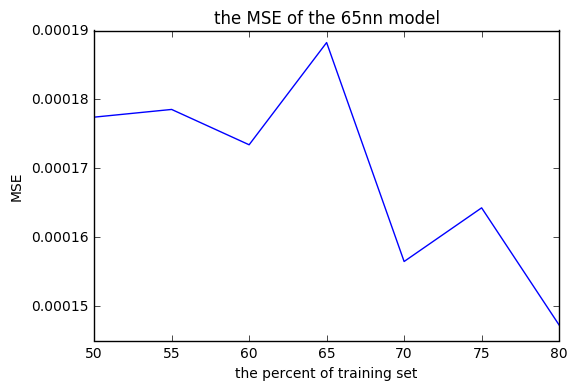

In [78]:
import pylab as pl
x = [50,55,60,65,70,75,80]
pl.plot(x, MSE_65)
pl.title('the MSE of the 65nn model')
pl.xlabel('the percent of training set')
pl.ylabel('MSE')
pl.show()

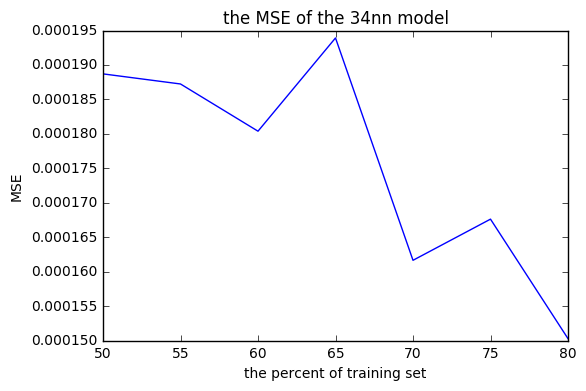

In [79]:

pl.plot(x, MSE_34)
pl.title('the MSE of the 34nn model')
pl.xlabel('the percent of training set')
pl.ylabel('MSE')
pl.show()

In [80]:

tr_list = [tr_set50, tr_set55, tr_set60, tr_set65, tr_set70, tr_set75, tr_set80]
te_list = [te_set50, te_set55, te_set60, te_set65, te_set70, te_set75, te_set80]
nei_65_list = [neighbours50_65, neighbours55_65,neighbours60_65,neighbours65_65,neighbours70_65, neighbours75_65, neighbours80_65]
nei_34_list = [neighbours50_34, neighbours55_34,neighbours60_34,neighbours65_34,neighbours70_34,neighbours75_34,neighbours80_34]

    

In [81]:
acc_65=[]
acc_34= []

In [82]:
for i in range(len(nei_65_list)):
    pred = prediction(tr_list[i], nei_65_list[i], te_list[i])
    predicted_recom = recommend_dic(tr_list[i], pred)
    real_recom = real_dic(tr_list[i],  te_list[i])
    res = {}
    for p_name in real_recom:
        pre_set = set(predicted_recom[p_name])
        rea_set = set(real_recom[p_name])
        res[p_name] = 1.0*len(pre_set.intersection(rea_set))/len(rea_set)
    acc_65.append(sum(res.values())/len(res.values()))
    print "Accuracy = " + str(acc_65[-1])

Accuracy = 0.536372448453
Accuracy = 0.582880275769
Accuracy = 0.649898955102
Accuracy = 0.682523291091
Accuracy = 0.738682322329
Accuracy = 0.764917907079
Accuracy = 0.801144177313


In [83]:
for i in range(len(nei_34_list)):
    pred = prediction(tr_list[i], nei_34_list[i], te_list[i])
    predicted_recom = recommend_dic(tr_list[i], pred)
    real_recom = real_dic(tr_list[i],  te_list[i])
    res = {}
    for p_name in real_recom:
        pre_set = set(predicted_recom[p_name])
        rea_set = set(real_recom[p_name])
        res[p_name] = 1.0*len(pre_set.intersection(rea_set))/len(rea_set)
    acc_34.append(sum(res.values())/len(res.values()))
    print "Accuracy = " + str(acc_34[-1])

Accuracy = 0.519688120984
Accuracy = 0.582471506546
Accuracy = 0.650870725046
Accuracy = 0.681135998879
Accuracy = 0.739997769457
Accuracy = 0.768549266015
Accuracy = 0.801911339718


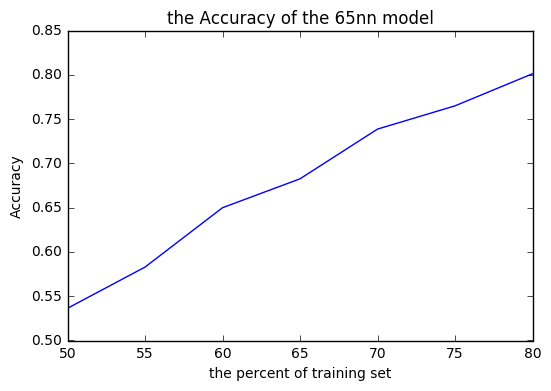

In [84]:
pl.plot(x, acc_65)
pl.title('the Accuracy of the 65nn model')
pl.xlabel('the percent of training set')
pl.ylabel('Accuracy')
pl.show()

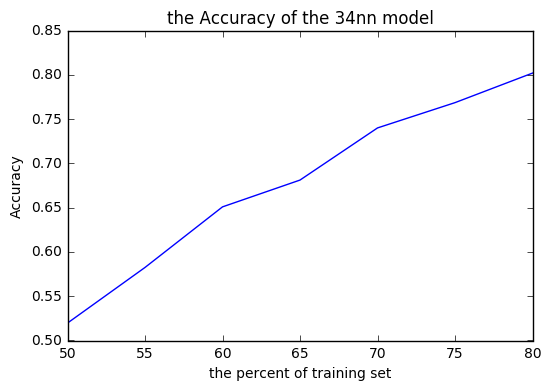

In [85]:
pl.plot(x, acc_34)
pl.title('the Accuracy of the 34nn model')
pl.xlabel('the percent of training set')
pl.ylabel('Accuracy')
pl.show()